In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# If the icetemperature library is not in your PYTHONPATH, you will not be able to load those functions
# Check and update here if necessary
import sys
cs_dir = '../'
if cs_dir not in sys.path:
    sys.path.append(cs_dir)

# Import the ice temperature model and relevant constants
from icetemperature.lib.numerical_model import ice_temperature
from icetemperature.lib.ice_properties import conductivity, heat_capacity
from icetemperature.lib.constants import constants
const = constants()

# Interpolator for density profile
from scipy.interpolate import interp1d

<IPython.core.display.Javascript object>


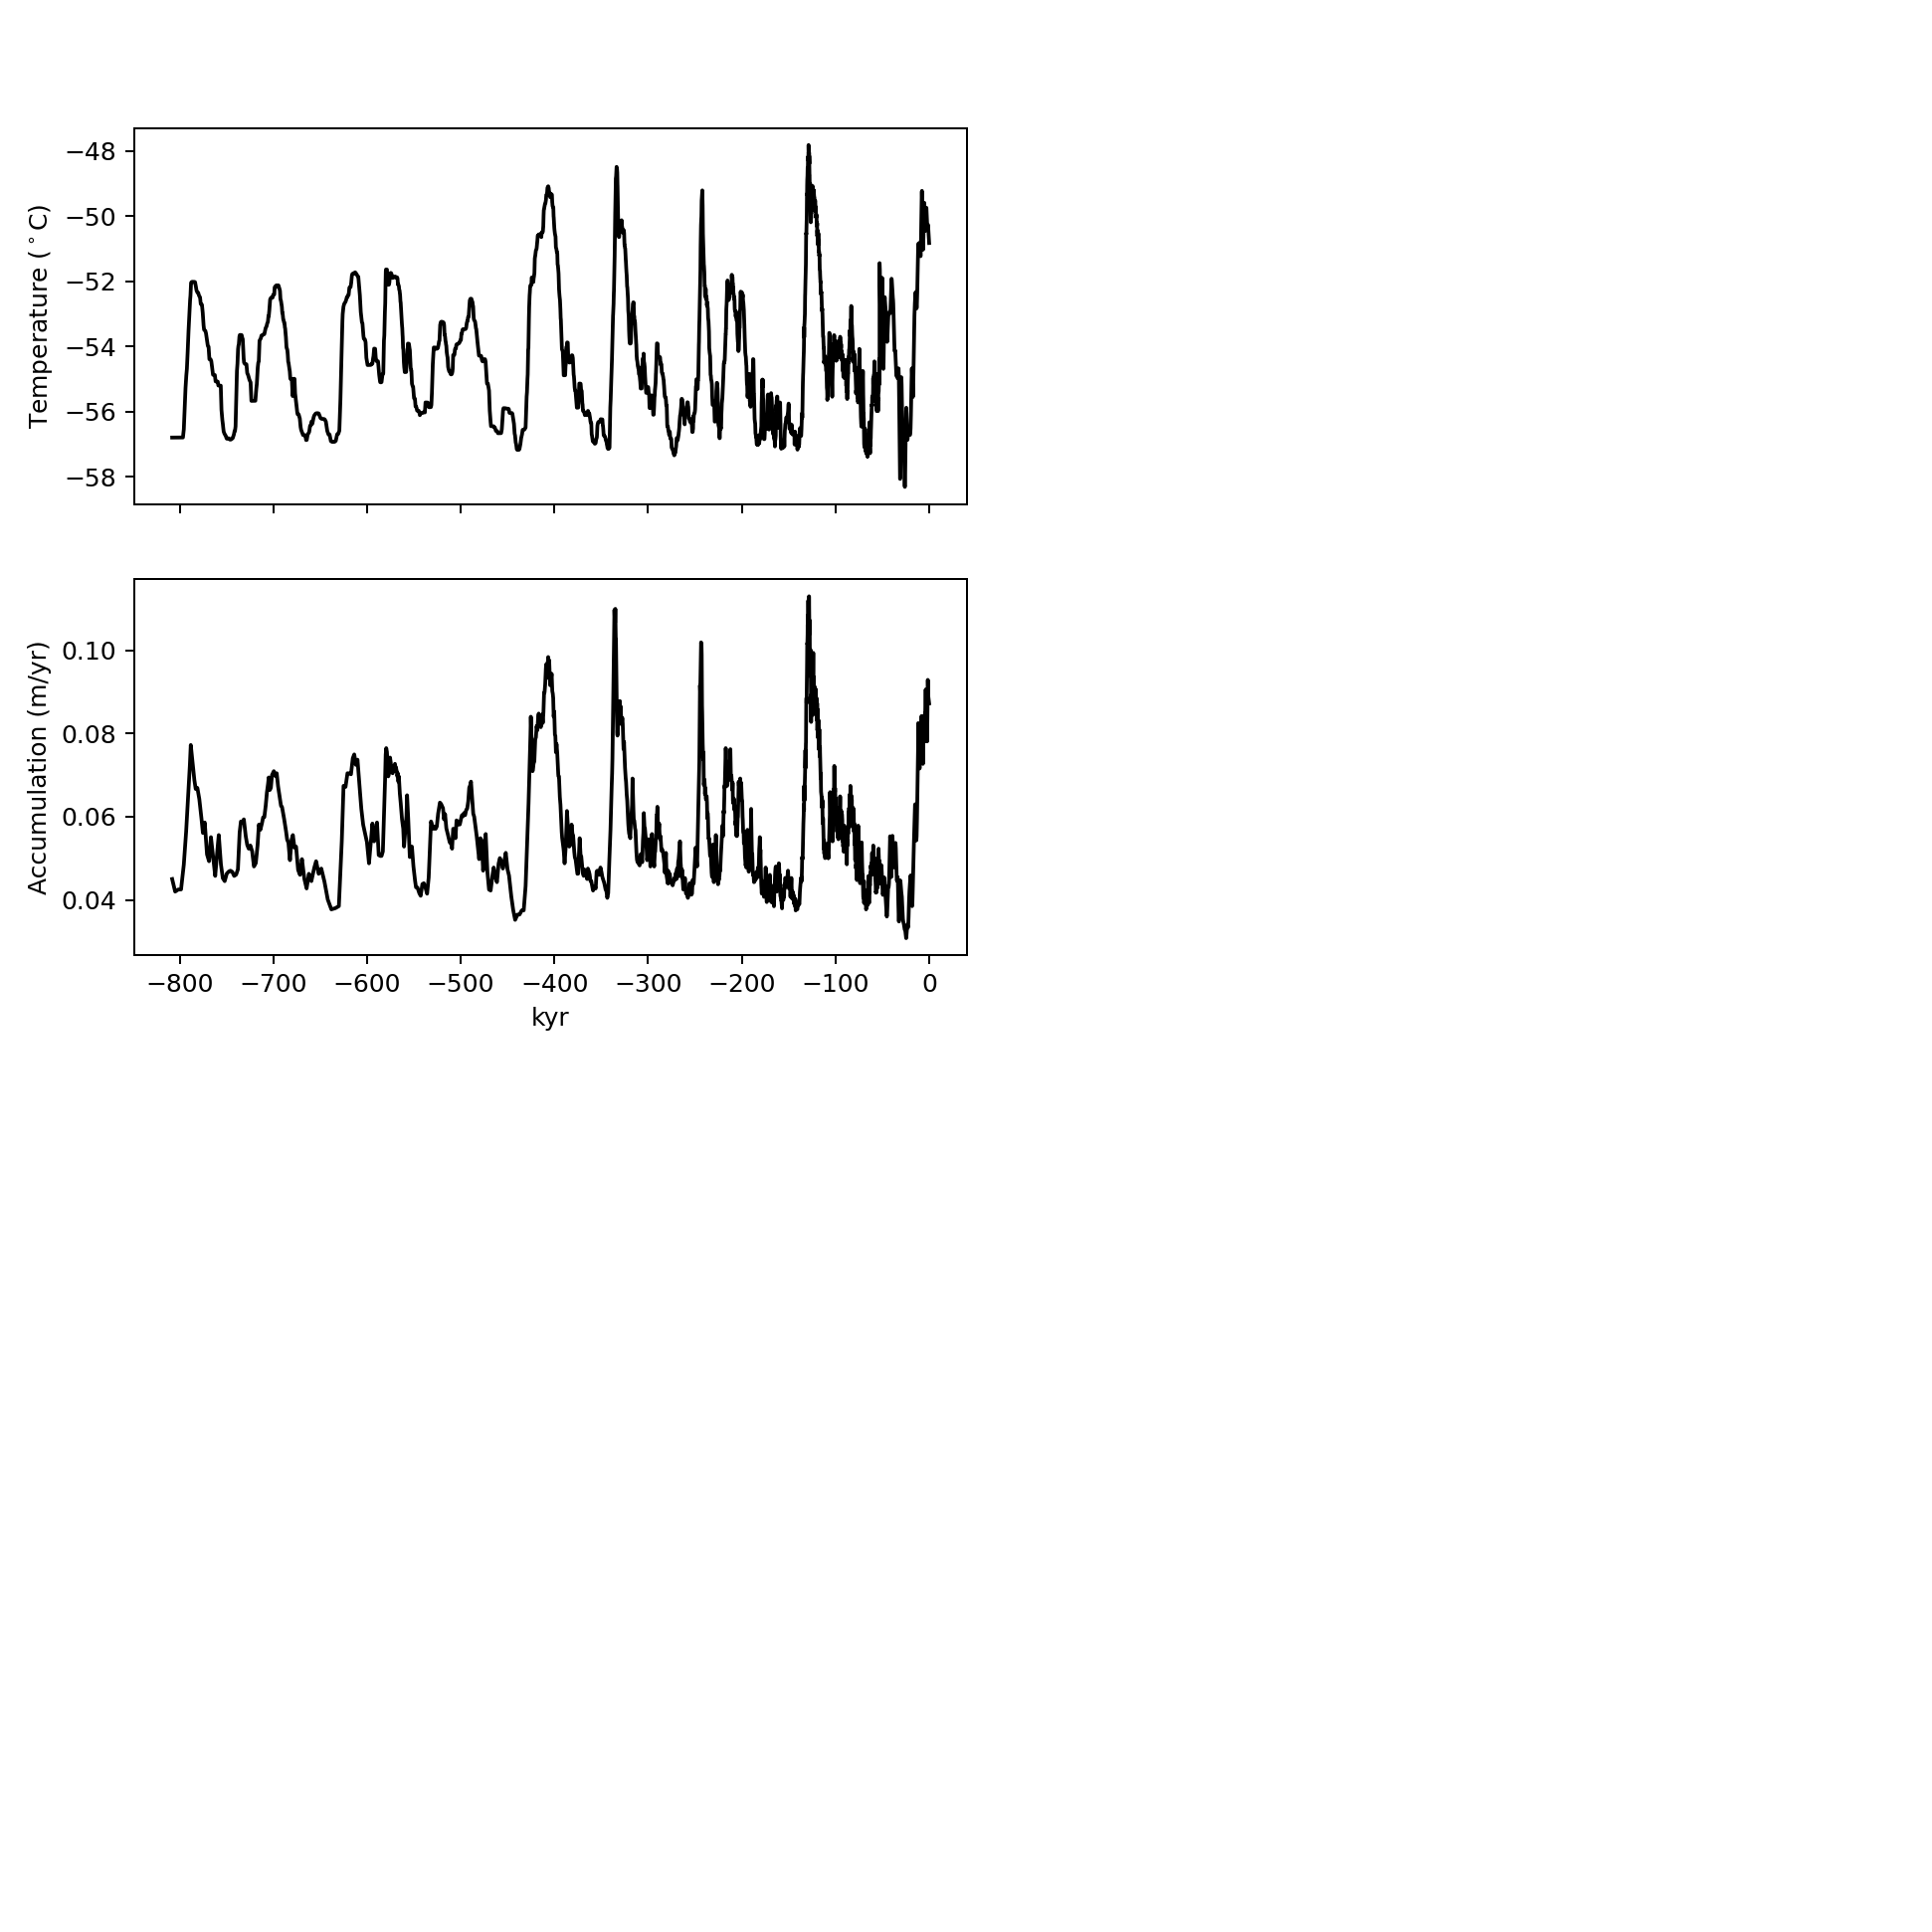

In [6]:
### Load Relevant Datasets

# Measured temperature profile (IceCube/AMANDA)
z_data,T_data,C_data = np.transpose(np.load('../data/compiled_insitu_icetemp.npy'))

# Scaled paleoclimate input from spicecore
model_accumulation = np.load('../data/paleoAccumulation.npy')
model_airTemp = np.load('../data/paleoAirTemperature.npy')
ts = model_accumulation[0]
adot = model_accumulation[1]
Tsurf = model_airTemp[1]

# Density data from spice core
data = np.genfromtxt('../data/SP19_Depth_Age.csv',skip_header=1,delimiter=',')
z_rho = data[:,0]
rho_data = data[:,5]

# Ice thickness from radar through IceCube array
H = 2880.
z_data[-1] = -H

# Assume that the bed is thawed
T_data[-1] = const.rho*const.g*const.beta*H

# Plot the figure to double check that the input data look good
plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
plt.tick_params(labelbottom=False)
ax1.plot((ts-np.max(ts))/1000.,Tsurf,'k')
plt.ylabel('Temperature ($^\circ$C)')
ax2 = plt.subplot(212)
ax2.plot((ts-np.max(ts))/1000.,adot,'k')
plt.ylabel('Accumulation (m/yr)')
plt.xlabel('kyr');

In [ ]:
# Instantiate the model class
m = ice_temperature()

# Set the time step to 5 years and subsample the paleoclimate data to match
m.ts = ts[::5]*const.spy
m.adot = adot[::5]/const.spy
m.Ts = Tsurf[::5]

# Set the model parameters
m.H = H
m.qgeo = .06
m.p = 1000.
m.Udef = 0.0/const.spy
m.Uslide = 9.3/const.spy

# Longitudinal advection forcing
m.dTs = 1.7e-5
m.dH = 0.003
m.da = 1e-8/const.spy
m.flags.append('weertman_vel')

# Thermal conductivity should be temperature and density dependent; set here
m.flags.append('temp-dependent')
m.initial_conditions()
rho_interpolator = interp1d(m.H-z_rho,rho_data,fill_value='extrapolate')
m.rho = 1000.*rho_interpolator(m.z)
m.k = conductivity(m.T.copy(),m.rho)
m.Cp = heat_capacity(m.T.copy())

# Initialize the model to steady state
m.source_terms()
m.stencil()
m.run_to_steady_state()

# Run the model
m.flags.append('save_all')
m.run()

Running model to steady state
...........
No velocity arrays set, setting to constant value.
t = -807941 ; dt = 5.0 ; melt rate = 0.74 ; melt cum =  0.0 ; q_b =  0.02665190055107171
t = -802941 ; dt = 5.0 ; melt rate = 0.7 ; melt cum =  3.54 ; q_b =  0.02665190055107171
t = -797941 ; dt = 5.0 ; melt rate = 0.71 ; melt cum =  7.07 ; q_b =  0.02665190055107171
t = -792941 ; dt = 5.0 ; melt rate = 0.64 ; melt cum =  10.5 ; q_b =  0.02665190055107171
t = -787941 ; dt = 5.0 ; melt rate = 0.43 ; melt cum =  13.24 ; q_b =  0.02665190055107171
t = -782941 ; dt = 5.0 ; melt rate = 0.27 ; melt cum =  14.87 ; q_b =  0.02665190055107171
t = -777941 ; dt = 5.0 ; melt rate = 0.27 ; melt cum =  16.16 ; q_b =  0.02665190055107171
t = -772941 ; dt = 5.0 ; melt rate = 0.37 ; melt cum =  17.76 ; q_b =  0.02665190055107171
t = -767941 ; dt = 5.0 ; melt rate = 0.51 ; melt cum =  19.96 ; q_b =  0.02665190055107171
t = -762941 ; dt = 5.0 ; melt rate = 0.59 ; melt cum =  22.7 ; q_b =  0.02665190055107171
t = 

t = -362941 ; dt = 5.0 ; melt rate = 0.67 ; melt cum =  229.29 ; q_b =  0.02665190055107171
t = -357941 ; dt = 5.0 ; melt rate = 0.7 ; melt cum =  232.69 ; q_b =  0.02665190055107171
t = -352941 ; dt = 5.0 ; melt rate = 0.7 ; melt cum =  236.22 ; q_b =  0.02665190055107171
t = -347941 ; dt = 5.0 ; melt rate = 0.68 ; melt cum =  239.67 ; q_b =  0.02665190055107171
t = -342941 ; dt = 5.0 ; melt rate = 0.7 ; melt cum =  243.09 ; q_b =  0.02665190055107171
t = -337941 ; dt = 5.0 ; melt rate = 0.57 ; melt cum =  246.41 ; q_b =  0.02665190055107171
t = -332941 ; dt = 5.0 ; melt rate = 0.09 ; melt cum =  248.01 ; q_b =  0.02665190055107171
t = -327941 ; dt = 5.0 ; melt rate = 0.0 ; melt cum =  248.1 ; q_b =  0.02665190055107171
t = -322941 ; dt = 5.0 ; melt rate = 0.0 ; melt cum =  248.1 ; q_b =  0.02665190055107171
t = -317941 ; dt = 5.0 ; melt rate = 0.27 ; melt cum =  248.74 ; q_b =  0.02665190055107171
t = -312941 ; dt = 5.0 ; melt rate = 0.4 ; melt cum =  250.41 ; q_b =  0.02665190055107

In [ ]:
# Plot the model output against the measured temperature profile
plt.figure(figsize=(4,4))
plt.plot(T_data[:-1],z_data[:-1],'k.',label='Measurements',ms=7,mfc='w',mew=1.5)
plt.plot(T_data[-1],z_data[-1],'.',c='indianred',label='Thawed Bed',ms=7,mfc='w',mew=1.5)
plt.plot(m.T,m.z-m.H,c='grey',label='Model')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^\circ$C)')
plt.legend()
plt.tight_layout()